In [1]:
import pandas as pd
import numpy as np

import librosa as lb
from librosa.display import specshow

import matplotlib.pyplot as plt
import seaborn as sns

import os
from os import listdir
from os.path import isfile, join

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.utils import class_weight

In [2]:
!ls ../input/spectrogram-images-all/

images


In [3]:
diagnosis_csv = '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv'
diagnosis = pd.read_csv(diagnosis_csv, names=['pId', 'diagnosis'])
diagnosis.head()

,pId,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [4]:
categories = sorted(diagnosis['diagnosis'].unique().tolist())
categories

['Asthma',
 'Bronchiectasis',
 'Bronchiolitis',
 'COPD',
 'Healthy',
 'LRTI',
 'Pneumonia',
 'URTI']

In [5]:
demographic_csv = '../input/respiratory-sound-database/demographic_info.txt'
demographic = pd.read_csv(demographic_csv, sep=' ', names=['pId', 'age', 'sex', 'adult_bmi', 'child_wt', 'child_ht'])
demographic.head()

,pId,age,sex,adult_bmi,child_wt,child_ht
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


In [6]:
demographic.drop(['adult_bmi', 'child_wt', 'child_ht'], axis=1, inplace=True)
demographic.head()

,pId,age,sex
0,101,3.00,F
1,102,0.75,F
2,103,70.00,F
3,104,70.00,F
4,105,7.00,F


In [7]:
diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
pId          126 non-null int64
diagnosis    126 non-null object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [8]:
demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 3 columns):
pId    126 non-null int64
age    125 non-null float64
sex    125 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ KB


In [9]:
df = pd.merge(diagnosis, demographic, on='pId')
df.head()

,pId,diagnosis,age,sex
0,101,URTI,3.00,F
1,102,Healthy,0.75,F
2,103,Asthma,70.00,F
3,104,COPD,70.00,F
4,105,URTI,7.00,F


In [10]:
path = '../input/spectrogram-images-all/images/'
files = [f for f in os.listdir(path = path)]

In [11]:
files_ = []
for file in files:
    pId = file.split('_')[0]
    files_.append([pId, file])

In [12]:
files_df = pd.DataFrame(files_, columns=['pId', 'filename'])
files_df.head()

,pId,filename
0,208,208_1b1_Ll_sc_Meditron_1.png
1,186,186_2b2_Lr_mc_AKGC417L_3.png
2,154,154_2b4_Ar_mc_AKGC417L_3.png
3,203,203_1p4_Ar_mc_AKGC417L_4.png
4,201,201_1b1_Ar_sc_Meditron_1.png


In [13]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5390 entries, 0 to 5389
Data columns (total 2 columns):
pId         5390 non-null object
filename    5390 non-null object
dtypes: object(2)
memory usage: 84.3+ KB


In [14]:
files_df['pId'] = files_df['pId'].astype('int64')
df = pd.merge(df, files_df, on='pId')
df.head()

,pId,diagnosis,age,sex,filename
0,101,URTI,3.0,F,101_1b1_Pr_sc_Meditron_7.png
1,101,URTI,3.0,F,101_1b1_Pr_sc_Meditron_5.png
2,101,URTI,3.0,F,101_1b1_Pr_sc_Meditron_0.png
3,101,URTI,3.0,F,101_1b1_Pr_sc_Meditron_1.png
4,101,URTI,3.0,F,101_1b1_Al_sc_Meditron_10.png


In [15]:
df.shape

(5390, 5)

In [16]:
!ls ../input/cnn-part-4-training-and-modelling

__notebook__.ipynb  __results__.html   custom.css
__output__.json     __results___files  res.h5


In [17]:
#load model
model_path = '../input/cnn-part-4-training-and-modelling/res.h5'
model = load_model(model_path)
model

In [18]:
batch_holder = np.zeros((df.shape[0], 224, 224, 3))

for i,img in enumerate(os.listdir(path)):
  img = load_img(os.path.join(path,img), target_size=(224,224))
  batch_holder[i, :] = img

In [19]:
result = model.predict(batch_holder)
result

array([[2.1506918e-09, 1.7575466e-03, 3.8150191e-02, ..., 2.8955800e-04,
        1.9655665e-04, 2.3027650e-01],
       [5.7951370e-06, 1.7546353e-11, 2.2779426e-10, ..., 2.0314856e-09,
        3.0554440e-03, 2.5939115e-10],
       [2.6274090e-06, 2.7713731e-06, 3.6129386e-10, ..., 7.3734708e-07,
        3.6101785e-04, 1.3678917e-05],
       ...,
       [6.6706662e-07, 2.0317400e-14, 5.7132580e-15, ..., 1.1836318e-12,
        3.9964802e-06, 1.1711924e-09],
       [1.0951369e-03, 1.6293505e-05, 3.6524997e-10, ..., 9.1656833e-04,
        8.6563587e-02, 8.1855757e-03],
       [1.8574119e-02, 1.0683599e-05, 2.1050870e-09, ..., 5.8268059e-05,
        6.1144564e-02, 9.6620177e-05]], dtype=float32)

In [20]:
result_max = np.argmax(result, axis=-1)
result_max

array([4, 3, 3, ..., 3, 3, 3])

In [21]:
np.unique(result_max)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [22]:
predictions = pd.DataFrame(result, columns=categories)
predictions.head()

,Asthma,Bronchiectasis,Bronchiolitis,COPD,Healthy,LRTI,Pneumonia,URTI
0,2.150692e-09,1.757547e-03,3.815019e-02,0.003045,7.262846e-01,2.895580e-04,0.000197,2.302765e-01
1,5.795137e-06,1.754635e-11,2.277943e-10,0.996939,1.326651e-13,2.031486e-09,0.003055,2.593911e-10
2,2.627409e-06,2.771373e-06,3.612939e-10,0.999618,9.231468e-07,7.373471e-07,0.000361,1.367892e-05
3,9.605336e-07,8.533218e-06,6.210126e-06,0.989107,5.239604e-04,1.476221e-03,0.002707,6.170190e-03
4,3.683348e-08,7.732258e-01,3.238447e-04,0.014780,2.018045e-01,3.197132e-04,0.000008,9.538185e-03


In [23]:
predictions.shape

(5390, 8)

In [24]:
final_df = df.merge(predictions, left_index=True, right_index=True)
final_df.head()

,pId,diagnosis,age,sex,filename,Asthma,Bronchiectasis,Bronchiolitis,COPD,Healthy,LRTI,Pneumonia,URTI
0,101,URTI,3.0,F,101_1b1_Pr_sc_Meditron_7.png,2.150692e-09,1.757547e-03,3.815019e-02,0.003045,7.262846e-01,2.895580e-04,0.000197,2.302765e-01
1,101,URTI,3.0,F,101_1b1_Pr_sc_Meditron_5.png,5.795137e-06,1.754635e-11,2.277943e-10,0.996939,1.326651e-13,2.031486e-09,0.003055,2.593911e-10
2,101,URTI,3.0,F,101_1b1_Pr_sc_Meditron_0.png,2.627409e-06,2.771373e-06,3.612939e-10,0.999618,9.231468e-07,7.373471e-07,0.000361,1.367892e-05
3,101,URTI,3.0,F,101_1b1_Pr_sc_Meditron_1.png,9.605336e-07,8.533218e-06,6.210126e-06,0.989107,5.239604e-04,1.476221e-03,0.002707,6.170190e-03
4,101,URTI,3.0,F,101_1b1_Al_sc_Meditron_10.png,3.683348e-08,7.732258e-01,3.238447e-04,0.014780,2.018045e-01,3.197132e-04,0.000008,9.538185e-03


In [25]:
final_df['sex'] = final_df['sex'].map({ 'M': 0, 'F': 1})

In [26]:
final_df.drop(['filename', 'pId'], axis=1, inplace=True)

In [27]:
final_df['sex'].fillna(0, inplace=True) #this is mode

In [28]:
final_df['age'].fillna(final_df['age'].describe().mean(), inplace=True)

In [29]:
label_encoder = LabelEncoder()
diag_encoded = label_encoder.fit_transform(final_df['diagnosis'])
diag_encoded

array([7, 7, 7, ..., 6, 6, 6])

In [30]:
np.unique(diag_encoded)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [31]:
final_df['diagnosis'] = diag_encoded

In [32]:
final_df.isnull().sum()

diagnosis         0
age               0
sex               0
Asthma            0
Bronchiectasis    0
Bronchiolitis     0
COPD              0
Healthy           0
LRTI              0
Pneumonia         0
URTI              0
dtype: int64

In [33]:
final_df.reset_index()
final_df.head()

,diagnosis,age,sex,Asthma,Bronchiectasis,Bronchiolitis,COPD,Healthy,LRTI,Pneumonia,URTI
0,7,3.0,1.0,2.150692e-09,1.757547e-03,3.815019e-02,0.003045,7.262846e-01,2.895580e-04,0.000197,2.302765e-01
1,7,3.0,1.0,5.795137e-06,1.754635e-11,2.277943e-10,0.996939,1.326651e-13,2.031486e-09,0.003055,2.593911e-10
2,7,3.0,1.0,2.627409e-06,2.771373e-06,3.612939e-10,0.999618,9.231468e-07,7.373471e-07,0.000361,1.367892e-05
3,7,3.0,1.0,9.605336e-07,8.533218e-06,6.210126e-06,0.989107,5.239604e-04,1.476221e-03,0.002707,6.170190e-03
4,7,3.0,1.0,3.683348e-08,7.732258e-01,3.238447e-04,0.014780,2.018045e-01,3.197132e-04,0.000008,9.538185e-03


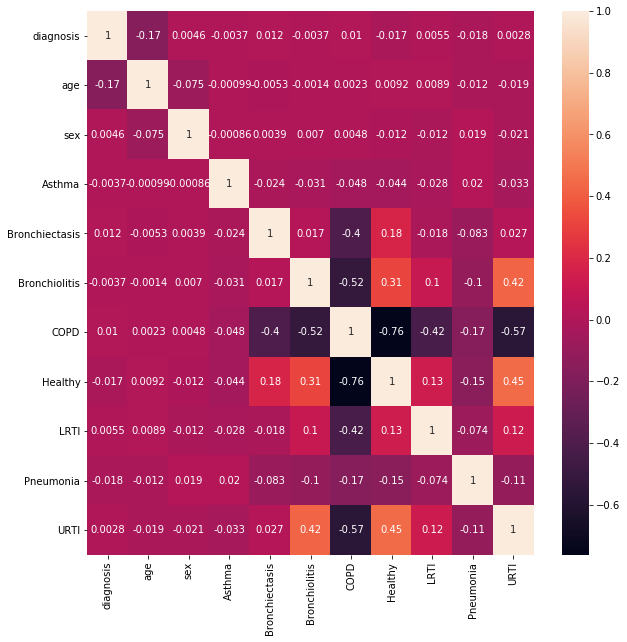

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(final_df.corr(), annot=True)

In [35]:
x = final_df.drop(['diagnosis'], axis=1)
y = final_df['diagnosis']

In [36]:
class_weights = class_weight.compute_class_weight(classes = y.unique(), y=y, class_weight='balanced')
class_weights

array([3.47293814e+00, 2.62159533e+00, 1.68437500e+02, 1.50693357e-01,
       2.69500000e+01, 8.11746988e+00, 2.95504386e+00, 5.26367188e+00])

In [37]:
weights = { i : class_weights[i] for i in range(len(class_weights)) }
weights

{0: 3.472938144329897,
 1: 2.6215953307392996,
 2: 168.4375,
 3: 0.15069335719078505,
 4: 26.95,
 5: 8.117469879518072,
 6: 2.955043859649123,
 7: 5.263671875}

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [39]:
x_train.head()

,age,sex,Asthma,Bronchiectasis,Bronchiolitis,COPD,Healthy,LRTI,Pneumonia,URTI
1584,56.0,1.0,1.711775e-05,1.361941e-06,5.331538e-08,0.973159,2.620121e-05,3.800772e-05,2.635403e-02,4.042077e-04
133,75.0,1.0,3.616694e-11,2.276726e-15,4.980724e-15,1.000000,2.068833e-17,4.791515e-11,3.487116e-07,3.212035e-10
2954,79.0,0.0,2.279062e-06,1.386713e-03,1.817763e-04,0.834902,3.612054e-03,5.243130e-04,1.534258e-01,5.964865e-03
1673,61.0,0.0,1.149383e-06,7.953020e-01,2.134558e-02,0.017066,1.507467e-01,9.988710e-03,1.510344e-04,5.399243e-03
827,85.0,1.0,4.357496e-06,9.127187e-06,1.839261e-06,0.992622,6.744714e-07,1.603812e-04,6.829076e-03,3.727296e-04


In [40]:
y_train

1584    3
133     3
2954    3
1673    3
827     3
       ..
905     3
5192    3
3980    6
235     3
5157    3
Name: diagnosis, Length: 4312, dtype: int64

In [41]:
l_model = LogisticRegression(max_iter=10000, class_weight=weights)
l_model

LogisticRegression(C=1.0,
                   class_weight={0: 3.472938144329897, 1: 2.6215953307392996,
                                 2: 168.4375, 3: 0.15069335719078505, 4: 26.95,
                                 5: 8.117469879518072, 6: 2.955043859649123,
                                 7: 5.263671875},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=10000, multi_class='auto',
                   n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

In [42]:
l_model.fit(x_train, y_train)
y_pred = l_model.predict(x_test)
y_pred

array([1, 3, 4, ..., 4, 3, 6])

In [43]:
print('accuracy (logistic regression): ' + str(metrics.accuracy_score(y_test, y_pred)))
print('f1 score (logistic regression): ' + str(metrics.f1_score(y_test, y_pred, average='weighted')))
print('recall (logistic regression): ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('f1 score (logistic regression all): ' + str(metrics.f1_score(y_test, y_pred, average=None)))
print('recall (logistic regression all): ' + str(metrics.recall_score(y_test, y_pred, average=None)))
print('precision (logistic regression all): ' + str(metrics.precision_score(y_test, y_pred, average=None)))

accuracy (logistic regression): 0.40816326530612246
f1 score (logistic regression): 0.5145521268501039
recall (logistic regression): 0.40816326530612246
f1 score (logistic regression all): [0.         0.1        0.3880597  0.57973291 0.4040404  0.
 0.08       0.        ]
recall (logistic regression all): [0.         0.22222222 1.         0.41600902 0.31746032 0.
 0.53846154 0.        ]
precision (logistic regression all): [0.         0.06451613 0.24074074 0.95595855 0.55555556 0.
 0.04320988 0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
dtree = DecisionTreeClassifier(class_weight=weights)
dtree

DecisionTreeClassifier(ccp_alpha=0.0,
                       class_weight={0: 3.472938144329897,
                                     1: 2.6215953307392996, 2: 168.4375,
                                     3: 0.15069335719078505, 4: 26.95,
                                     5: 8.117469879518072, 6: 2.955043859649123,
                                     7: 5.263671875},
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [45]:
dtree.fit(x_train, y_train)
y_pred = dtree.predict(x_test)
y_pred

array([3, 3, 6, ..., 4, 3, 6])

In [46]:
print('accuracy (decision tree): ' + str(metrics.accuracy_score(y_test, y_pred)))
print('f1 score (decision tree): ' + str(metrics.f1_score(y_test, y_pred, average='weighted')))
print('recall (decision tree): ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('f1 score (decision tree all): ' + str(metrics.f1_score(y_test, y_pred, average=None)))
print('recall (decision tree all): ' + str(metrics.recall_score(y_test, y_pred, average=None)))
print('precision (decision tree all): ' + str(metrics.precision_score(y_test, y_pred, average=None)))

accuracy (decision tree): 0.924860853432282
f1 score (decision tree): 0.9274619362144052
recall (decision tree): 0.924860853432282
f1 score (decision tree all): [0.         0.62222222 0.65384615 0.9738041  0.848      0.66666667
 0.65168539 0.65853659]
recall (decision tree all): [0.         0.77777778 0.65384615 0.96392334 0.84126984 0.66666667
 0.74358974 0.65853659]
precision (decision tree all): [0.         0.51851852 0.65384615 0.98388953 0.85483871 0.66666667
 0.58       0.65853659]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
rforest = RandomForestClassifier(class_weight=weights)
rforest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 3.472938144329897,
                                     1: 2.6215953307392996, 2: 168.4375,
                                     3: 0.15069335719078505, 4: 26.95,
                                     5: 8.117469879518072, 6: 2.955043859649123,
                                     7: 5.263671875},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
rforest.fit(x_train, y_train)
y_pred = rforest.predict(x_test)
y_pred

array([3, 3, 6, ..., 7, 3, 3])

In [49]:
print('accuracy (random forest): ' + str(metrics.accuracy_score(y_test, y_pred)))
print('f1 score (random forest): ' + str(metrics.f1_score(y_test, y_pred, average='weighted')))
print('recall (random forest): ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('f1 score (random forest all): ' + str(metrics.f1_score(y_test, y_pred, average=None)))
print('recall (random forest all): ' + str(metrics.recall_score(y_test, y_pred, average=None)))
print('precision (random forest all): ' + str(metrics.precision_score(y_test, y_pred, average=None)))

accuracy (random forest): 0.9016697588126159
f1 score (random forest): 0.8873646038541749
recall (random forest): 0.9016697588126159
f1 score (random forest all): [0.         0.         0.46153846 0.96859504 0.76190476 0.8
 0.32727273 0.54320988]
recall (random forest all): [0.         0.         0.46153846 0.99098083 0.76190476 0.66666667
 0.23076923 0.53658537]
precision (random forest all): [0.         0.         0.46153846 0.94719828 0.76190476 1.
 0.5625     0.55      ]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
mlp = MLPClassifier(max_iter=10000, learning_rate='adaptive')
mlp

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [51]:
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
y_pred

array([3, 3, 7, ..., 7, 3, 3])

In [52]:
print('accuracy (mlp): ' + str(metrics.accuracy_score(y_test, y_pred)))
print('f1 score (mlp): ' + str(metrics.f1_score(y_test, y_pred, average='weighted')))
print('recall (mlp): ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('f1 score (mlp all): ' + str(metrics.f1_score(y_test, y_pred, average=None)))
print('recall (mlp all): ' + str(metrics.recall_score(y_test, y_pred, average=None)))
print('precision (mlp all): ' + str(metrics.precision_score(y_test, y_pred, average=None)))

accuracy (mlp): 0.9053803339517625
f1 score (mlp): 0.8801090328174545
recall (mlp): 0.9053803339517625
f1 score (mlp all): [0.         0.         0.54166667 0.97419001 0.70175439 0.
 0.         0.64285714]
recall (mlp all): [0.         0.         0.5        1.         0.63492063 0.
 0.         0.87804878]
precision (mlp all): [0.         0.         0.59090909 0.9496788  0.78431373 0.
 0.         0.50704225]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
svc = SVC(class_weight=weights)
svc

SVC(C=1.0, break_ties=False, cache_size=200,
    class_weight={0: 3.472938144329897, 1: 2.6215953307392996, 2: 168.4375,
                  3: 0.15069335719078505, 4: 26.95, 5: 8.117469879518072,
                  6: 2.955043859649123, 7: 5.263671875},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [54]:
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
y_pred

array([3, 3, 2, ..., 2, 3, 3])

In [55]:
print('accuracy (svc): ' + str(metrics.accuracy_score(y_test, y_pred)))
print('f1 score (svc): ' + str(metrics.f1_score(y_test, y_pred, average='weighted')))
print('recall (svc): ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('f1 score (svc all): ' + str(metrics.f1_score(y_test, y_pred, average=None)))
print('recall (svc all): ' + str(metrics.recall_score(y_test, y_pred, average=None)))
print('precision (svc all): ' + str(metrics.precision_score(y_test, y_pred, average=None)))

accuracy (svc): 0.6706864564007421
f1 score (svc): 0.7245816950118605
recall (svc): 0.6706864564007421
f1 score (svc all): [0.         0.         0.3537415  0.84275948 0.37209302 0.
 0.02390438 0.        ]
recall (svc all): [0.         0.         1.         0.7643743  0.25396825 0.
 0.07692308 0.        ]
precision (svc all): [0.         0.         0.21487603 0.93905817 0.69565217 0.
 0.01415094 0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---------------------

In [56]:
df_with_max = df.merge(pd.DataFrame(result_max), left_index=True, right_index=True)
df_with_max.head()

,pId,diagnosis,age,sex,filename,0
0,101,URTI,3.0,F,101_1b1_Pr_sc_Meditron_7.png,4
1,101,URTI,3.0,F,101_1b1_Pr_sc_Meditron_5.png,3
2,101,URTI,3.0,F,101_1b1_Pr_sc_Meditron_0.png,3
3,101,URTI,3.0,F,101_1b1_Pr_sc_Meditron_1.png,3
4,101,URTI,3.0,F,101_1b1_Al_sc_Meditron_10.png,1


In [57]:
df_with_max.drop(['pId', 'filename'], axis=1, inplace=True)

In [58]:
df_with_max.rename(columns={'diagnosis': 'diagnosis', 'age': 'age', 'sex': 'sex', 0: 'prediction'}, inplace=True)
df_with_max.head()

,diagnosis,age,sex,prediction
0,URTI,3.0,F,4
1,URTI,3.0,F,3
2,URTI,3.0,F,3
3,URTI,3.0,F,3
4,URTI,3.0,F,1


In [59]:
df_with_max['age'].fillna(df_with_max['age'].describe().mean(), inplace=True)

In [60]:
df_with_max['sex'].fillna(df_with_max['sex'].describe().top, inplace=True)

In [61]:
df_with_max['sex'] = df_with_max['sex'].map({'M': 0, 'F': 1})

In [62]:
label_encoder = LabelEncoder()
diag_encoded = label_encoder.fit_transform(df_with_max['diagnosis'])
diag_encoded

array([7, 7, 7, ..., 6, 6, 6])

In [63]:
df_with_max['diagnosis'] = diag_encoded

In [64]:
df_with_max.isnull().sum()

diagnosis     0
age           0
sex           0
prediction    0
dtype: int64

In [65]:
df_with_max.head()

,diagnosis,age,sex,prediction
0,7,3.0,1,4
1,7,3.0,1,3
2,7,3.0,1,3
3,7,3.0,1,3
4,7,3.0,1,1


In [66]:
x = df_with_max.drop(['diagnosis'], axis=1)
y = df_with_max['diagnosis']

In [67]:
weights = { i : class_weights[i] for i in range(len(class_weights)) }
weights

{0: 3.472938144329897,
 1: 2.6215953307392996,
 2: 168.4375,
 3: 0.15069335719078505,
 4: 26.95,
 5: 8.117469879518072,
 6: 2.955043859649123,
 7: 5.263671875}

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [69]:
l_model = LogisticRegression(max_iter=10000, class_weight=weights)
l_model.fit(x_train, y_train)
y_pred = l_model.predict(x_test)
y_pred

array([1, 3, 2, ..., 4, 3, 6])

In [70]:
print('accuracy (logistic regression): ' + str(metrics.accuracy_score(y_test, y_pred)))
print('f1 score (logistic regression): ' + str(metrics.f1_score(y_test, y_pred, average='weighted')))
print('recall (logistic regression): ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('f1 score (logistic regression all): ' + str(metrics.f1_score(y_test, y_pred, average=None)))
print('recall (logistic regression all): ' + str(metrics.recall_score(y_test, y_pred, average=None)))
print('precision (logistic regression all): ' + str(metrics.precision_score(y_test, y_pred, average=None)))

accuracy (logistic regression): 0.40630797773654914
f1 score (logistic regression): 0.510975890445845
recall (logistic regression): 0.40630797773654914
f1 score (logistic regression all): [0.         0.08510638 0.38235294 0.57616417 0.39175258 0.
 0.09284333 0.        ]
recall (logistic regression all): [0.         0.22222222 1.         0.41149944 0.3015873  0.
 0.61538462 0.        ]
precision (logistic regression all): [0.         0.05263158 0.23636364 0.96052632 0.55882353 0.
 0.05020921 0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
dtree = DecisionTreeClassifier(max_depth=8, class_weight=weights)
dtree.fit(x_train, y_train)
y_pred = dtree.predict(x_test)
y_pred

array([1, 3, 7, ..., 7, 3, 6])

In [72]:
print('accuracy (decision tree): ' + str(metrics.accuracy_score(y_test, y_pred)))
print('f1 score (decision tree): ' + str(metrics.f1_score(y_test, y_pred, average='weighted')))
print('recall (decision tree): ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('f1 score (decision tree all): ' + str(metrics.f1_score(y_test, y_pred, average=None)))
print('recall (decision tree all): ' + str(metrics.recall_score(y_test, y_pred, average=None)))
print('precision (decision tree all): ' + str(metrics.precision_score(y_test, y_pred, average=None)))

accuracy (decision tree): 0.8153988868274582
f1 score (decision tree): 0.8534505753551372
recall (decision tree): 0.8153988868274582
f1 score (decision tree all): [0.         0.32727273 0.60465116 0.90438001 0.87719298 0.8
 0.42384106 0.53731343]
recall (decision tree all): [0.         1.         1.         0.82638106 0.79365079 0.66666667
 0.82051282 0.43902439]
precision (decision tree all): [0.         0.19565217 0.43333333 0.9986376  0.98039216 1.
 0.28571429 0.69230769]


In [73]:
rforest = RandomForestClassifier(class_weight=weights)
rforest.fit(x_train, y_train)
y_pred = rforest.predict(x_test)
y_pred

array([1, 3, 7, ..., 7, 3, 6])

In [74]:
print('accuracy (random forest): ' + str(metrics.accuracy_score(y_test, y_pred)))
print('f1 score (random forest): ' + str(metrics.f1_score(y_test, y_pred, average='weighted')))
print('recall (random forest): ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('f1 score (random forest all): ' + str(metrics.f1_score(y_test, y_pred, average=None)))
print('recall (random forest all): ' + str(metrics.recall_score(y_test, y_pred, average=None)))
print('precision (random forest all): ' + str(metrics.precision_score(y_test, y_pred, average=None)))

accuracy (random forest): 0.852504638218924
f1 score (random forest): 0.8798217435511624
recall (random forest): 0.852504638218924
f1 score (random forest all): [0.         0.33663366 0.6097561  0.93045564 0.875      0.66666667
 0.50877193 0.5915493 ]
recall (random forest all): [0.         0.94444444 0.96153846 0.87485908 0.77777778 0.66666667
 0.74358974 0.51219512]
precision (random forest all): [0.         0.20481928 0.44642857 0.99359795 1.         0.66666667
 0.38666667 0.7       ]


In [75]:
mlp = MLPClassifier(max_iter=10000, learning_rate='adaptive')
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
y_pred

array([3, 3, 7, ..., 7, 3, 3])

In [76]:
print('accuracy (mlp): ' + str(metrics.accuracy_score(y_test, y_pred)))
print('f1 score (mlp): ' + str(metrics.f1_score(y_test, y_pred, average='weighted')))
print('recall (mlp): ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('f1 score (mlp all): ' + str(metrics.f1_score(y_test, y_pred, average=None)))
print('recall (mlp all): ' + str(metrics.recall_score(y_test, y_pred, average=None)))
print('precision (mlp all): ' + str(metrics.precision_score(y_test, y_pred, average=None)))

accuracy (mlp): 0.9025974025974026
f1 score (mlp): 0.8786826329688079
recall (mlp): 0.9025974025974026
f1 score (mlp all): [0.         0.10526316 0.57692308 0.97365532 0.66129032 0.
 0.         0.61052632]
recall (mlp all): [0.         0.05555556 0.57692308 1.         0.65079365 0.
 0.         0.70731707]
precision (mlp all): [0.         1.         0.57692308 0.9486631  0.67213115 0.
 0.         0.53703704]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
svc = SVC(class_weight=weights)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
y_pred

array([3, 3, 2, ..., 2, 6, 3])

In [78]:
print('accuracy (svc): ' + str(metrics.accuracy_score(y_test, y_pred)))
print('f1 score (svc): ' + str(metrics.f1_score(y_test, y_pred, average='weighted')))
print('recall (svc): ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('f1 score (svc all): ' + str(metrics.f1_score(y_test, y_pred, average=None)))
print('recall (svc all): ' + str(metrics.recall_score(y_test, y_pred, average=None)))
print('precision (svc all): ' + str(metrics.precision_score(y_test, y_pred, average=None)))

accuracy (svc): 0.46938775510204084
f1 score (svc): 0.5768309317367691
recall (svc): 0.4693877551020408
f1 score (svc all): [0.         0.         0.3537415  0.6627907  0.37209302 0.
 0.03305785 0.        ]
recall (svc all): [0.         0.         1.         0.51409245 0.25396825 0.
 0.20512821 0.        ]
precision (svc all): [0.         0.         0.21487603 0.93251534 0.69565217 0.
 0.01797753 0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
